# Distributed Computation

## Quick Recap - Multiprocessing vs. Multithreading

Multiprocessing can utilize multiple CPU cores, thus achieving a more authentic sense of parallel computation. However, multiprocessing suffers when they need to share a common memory space.

On the other hand, multithreading can share a common memory space and achieve a more loose sense of parallel computation. As a result, multithreading is more like hyper-jumping through multiple queues (within the same process) while waiting for each particular thread's turn:

1. When it is one specific thread's turn, it will acquire the Global Interpreter Lock (GIL) to control the memory space _and_ the CPU core until it finishes its designated computation or hits another "busy-waiting" block (such as I/O actions).
2. Then, the loop releases the GIL and lets the jump proceed (context-switch) to the following thread.
3. Rinse and repeat (until done).

You can revisit [part 13](../13-data-processing.ipynb) for more details on this subject.

### Asynchronous I/O Loops, and Multithreading's Little Brother - Coroutines

Both multiprocessing and multithreading require dedicated hardware or operating system support. As software technologies mature, engineers started to explore capabilities within the application layer itself. As a result, the same conceptual model of multithreading gets a new interpretation within the programming stack (such as Python), giving more direct control to the program within the runtime instead of relying on the OS mechanism to switch context. The term [_Coroutine_](https://en.wikipedia.org/wiki/Coroutine), first coined in 1958, is a materialization of the concept of lightweight threads.

Both multithreading and coroutine techniques are suitable for I/O focused tasks, such as reading files from a disk or making HTTP requests. However, coroutines tend to require less computing resource overhead than threads by giving up some performance benefit from tapping into the more OS-native mechanisms.

In [1]:
import random
import requests


# 5 requests, each with delays ranging from 1-3 seconds
reqs = [
    f'https://httpbin.org/delay/{random.randint(1, 3)}'
    for _ in range(5)
]

def get_sync():
    all_data = []
    for req in reqs:
        res = requests.get(req)
        all_data.append(res.json())

    return all_data

In [2]:
%time res = get_sync()
print(res[-1], len(res))

CPU times: user 84.2 ms, sys: 10.3 ms, total: 94.5 ms
Wall time: 10.5 s
{'args': {}, 'data': '', 'files': {}, 'form': {}, 'headers': {'Accept': '*/*', 'Accept-Encoding': 'gzip, deflate', 'Host': 'httpbin.org', 'User-Agent': 'python-requests/2.25.1', 'X-Amzn-Trace-Id': 'Root=1-60d65367-3503a36e56f6d53f2ca31a75'}, 'origin': '107.179.188.69', 'url': 'https://httpbin.org/delay/1'} 5


In Python, [the `asyncio` module](https://docs.python.org/3/library/asyncio.html) provides a standard set of APIs for its users to utilize coroutines.

In [3]:
import asyncio

import aiohttp


async def get(session, url):
    res = await session.request('GET', url=url)
    data = await res.json()
    return data


async def main():
    async with aiohttp.ClientSession() as session:
        tasks = []
        for req in reqs:
            tasks.append(get(session, url=req))

        all_data = await asyncio.gather(*tasks, return_exceptions=True)
        return all_data

There are two caveats about utilizing `asyncio` in the Jupyter Notebook environment:
1. We cannot use the %time magic command for async functions.
2. We cannot initiate an explicit event loop (it's already in one).

In [4]:
import time

# loop = asyncio.get_event_loop()
# loop.run_until_complete(main())
start = time.time()
res = await main()
print(round(time.time() - start, 1), 'seconds')
print(res[-1], len(res))

3.3 seconds
{'args': {}, 'data': '', 'files': {}, 'form': {}, 'headers': {'Accept': '*/*', 'Accept-Encoding': 'gzip, deflate', 'Host': 'httpbin.org', 'User-Agent': 'Python/3.8 aiohttp/3.7.4.post0', 'X-Amzn-Trace-Id': 'Root=1-60d65368-2ca9bf10688e9d1638a9e1bb'}, 'origin': '107.179.188.69', 'url': 'https://httpbin.org/delay/1'} 5


Let's use the responses to verify what the delays were in the API calls by using functional techniques `map()` and `reduce()` to extract delays (in seconds) and sum them up.

In [5]:
def delay_mapper(url):
    return int(url.split('/')[-1])

delays = list(map(delay_mapper, reqs))
delays

[3, 3, 1, 1, 1]

In [6]:
from functools import reduce

def delay_reducer(left, right):
    return left + right

# same as calling `sum(delays)`
total_delay = reduce(delay_reducer, delays, 0)
total_delay

9

The total theoretical delay matches our observation from the synchronous process, while the _maximum_ from individual delays matches what we saw from the asynchronous version.

## MapReduce - Distributing Computing Resources

Recall one of the most critical disadvantages of multiprocessing - the lack of shared memory space. One workaround of such an issue is to leverage the filesystem as an inter-process data pool so that multiple processes can simultaneously read and write to it, such as a local SQLite database, as demonstrated in [part 11](../11-work-with-sql.ipynb).

Suppose we extend this problem to a larger scale, where the dataset we want to work with exceeds the available memory space and is impossible to efficiently store (or at all) on the disk of a single machine. In that case, we need to revisit viable solutions.

The MapReduce model is a _divide and conquer_ strategy applying and extending the functional programming concepts of `map()` and `reduce()`. Through this model, a large dataset is dissected and distributed through a mapping procedure onto a multitude of computational nodes to parallelize the computation of the smaller portion, then reducing the resulting subsets back to fewer nodes until the cluster concludes the outcome.

A simple demonstration of how the MapReduce model helps with tallying the number of occurrences of unique words of a given paragraph:

![MapReduceImage](https://user-images.githubusercontent.com/58446818/123367276-adc9a600-d547-11eb-9a37-5b91ce2eb090.png)

This model allows batch data processing to have a near-infinite capacity and a relatively cost-effective way to speed up the process.

It is worth noting that the development of cheaper and faster hard drives, especially the more widespread adoption of SSDs (solid-state drive), plays a vital role in enabling distributed computation.

The MapReduce model was first pioneered [by Google](https://research.google/pubs/pub62/) in 2004 to resolve the practical problem of exponentially growing datasets for computing their search indexes. Then many have adopted and contributed toward the technology's development and evolution through the open-source community.

### Apache Spark™

Apache Spark is such an open-source framework that came around 2014 that provides an elegant and unified abstraction on top of proven technologies such as SQL to enable large-scale data processing that can efficiently utilize from a single machine to "multiple clouds." You can find more comprehensive examples in [Spark's DataFrame usage notebook](./spark-dataframe-usage.ipynb).

For the sake of simplicity, we will demonstrate its distributed nature on multiple cores of a single machine. First, obtain the number of CPU core:

In [1]:
import multiprocessing

CORES = multiprocessing.cpu_count()
CORES

12

Borrowing from [part 12](../12-generate-data.ipynb), where we attempted to generate random and hashed device IDs:

In [2]:
# mostly from Part 12 - Generate data
from uuid import uuid4
from hashlib import sha1


def gen_device_ids(count: int = 20_000) -> list:
    device_ids = []
    for _ in range(count):
        device_ids.append(str(uuid4()))
    # hash
    return [sha1(x.encode()).hexdigest() for x in device_ids]

Let's generate a relatively large batch of device IDs, say 1 million times the number of `CORES`:

In [3]:
%time device_ids = gen_device_ids(count=1_000_000 * CORES)

CPU times: user 51.6 s, sys: 5.12 s, total: 56.7 s
Wall time: 56.8 s


Due to the single iterative process, the time it takes is quite long.

In [4]:
%time device_ids[:10]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


['7cd2e83fb6522438401ce0660ea33df317643282',
 'dc0a36109d57c76f18ef47ff1f03ed84adcf7c37',
 'c98398a8467c710fec4f568fa89052dd73f8e251',
 '6683b63b4e74d5086ea43277427c2c4e5895f3a1',
 '2be582b3bc39baa328314b262a4c0b235c6cbd31',
 '7588c798e2adf327ebf0ebed38258ae31c014797',
 'beff860ca260e4a672357ca82d88f494c4215d82',
 'e6bbd6fd9e896dfe67f5feb7894b12d01158d086',
 'c9fb0404b1b233327535b9e9af5a1b66fb288d8b',
 '07d56f7665a4d4ffd25a4d270d844a65be63f8ae']

In [5]:
%time len(device_ids)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


12000000

In [6]:
# get size of the list in memory
import sys

sys.getsizeof(device_ids) / 1024 / 1024  # (bytes / 1024 = kilobytes) / 1024 = megabytes

98.40396881103516

But since the list is already in memory, it takes very little time to read them out.

Let's try the same device ID generation with Spark in a distributed manner. We will initiate a Spark session with a local "master" that takes advantage of the number of `CORES` we have obtained.

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master(f'local[{CORES}]').getOrCreate()
spark

The Spark UI, which runs on the `localhost`, is handy for monitoring and more.

![Spark UI](https://user-images.githubusercontent.com/2837532/122995953-46a9c700-d378-11eb-84a7-50917d34b7be.png)

The first approach involves a core concept and building block of Spark, known as Resilient Distributed Datasets (`RDD`s).

In [8]:
%%time

def mapper(count):
    return [(d,) for d in gen_device_ids(count)]

# a list of [1_000_000, ..., 1_000_000], where the length is the number of CORES
counts = [1_000_000] * CORES

rdd = spark.sparkContext.parallelize(counts).flatMap(mapper)

CPU times: user 2.28 ms, sys: 1.92 ms, total: 4.2 ms
Wall time: 211 ms


The action takes a context from the available Spark session, scheduled to parallelize over a list of 1 million counts, where the list length is the number of `CORES`. Then we instruct the parallelization to map the Python list over a `mapper` function that takes the individual count and generates a list of device IDs (single element tuples). The `.flatMap` method is a convenient layer to ensure the resulting dataset as a single-tier list of device IDs instead of a list of (number of `CORES`) lists.

Notice the time it takes to schedule is negligible, as Spark takes a _lazy_ approach to preserve computing resources until the computation is needed.

In [9]:
sys.getsizeof(rdd)  # in bytes

48

In [10]:
%time sample = rdd.take(10)
print(sample)
print(sys.getsizeof(sample))

CPU times: user 4.81 ms, sys: 2.35 ms, total: 7.16 ms
Wall time: 5.85 s
[('e91f9dc25c999662f850099e376f9f32fef205be',), ('2e67b668cb133c986aaf17abd9f5de02364abbeb',), ('c4f854dd3e58bfe3c6b509fdddbac9ed4136b55e',), ('9c3cf2cb226493cc7765de7cf2ec8568c5b55aa5',), ('d0a8f37d2a5bfe2009ea78ff6bd1980670f70316',), ('45eb2d467a1fc60ae2952ffa04d8f0a62dcf4585',), ('23483d77ae73f81d9146dab2bdc48a1e5b1c53d7',), ('66d3e32addcb2947fe4e143e04b8e45c1a52c2bb',), ('d6bac44706bc878615035418c8bbd664f33a0ead',), ('3a6ce532ac5a07ddcd6dd659eab8492c501936a8',)]
136


Indeed, when we instruct to take the first ten values from the RDD, Spark would start the computation (and more). If we go back to the Spark UI, it may better picture what Spark has done under the hood.

![RDD take](https://user-images.githubusercontent.com/2837532/122997519-16fbbe80-d37a-11eb-8704-5c520019e161.png)

Conceptually, the workflow is as the following:
1. Generate the device IDs leveraging multiple `CORES` in parallel.
2. Persist device IDs as RDD into distributed blocks on disk. They have also replicated automatically across available distributions to support further parallelized processes. Spark also records other necessary metadata, such as the order of values, to ensure that computations that require strict ordering do not get affected.
3. Draw the first ten values from the RDD files and populates them into the Python process that runs this Notebook.

This workflow means that while it is significantly faster to generate the device IDs than the single process iterative approach, it is much slower to read. It involves a more complex trip to read from files while ensuring the order of values is intact.

`RDD`s can be cached into memory (the part that has been computed):

In [11]:
%time rdd = rdd.cache()

CPU times: user 2.56 ms, sys: 1.48 ms, total: 4.04 ms
Wall time: 8.7 ms


In [12]:
%time rdd.take(10)  # first call to heat-up the cache

CPU times: user 5.71 ms, sys: 2.68 ms, total: 8.38 ms
Wall time: 5.17 s


[('c9324dbf49f601913389f91298819376c640252b',),
 ('54893f6f30c9fb488aa6ff0bc2cfef88eefbabdc',),
 ('0e089056983e9b613182614d781786fdca0c9383',),
 ('6b1064d8b83b14cfde476acc293abdf3cd9f8a1f',),
 ('4c71081fd137a66e7be0c5a49d8b9067250567c6',),
 ('12bcc13563bd78d09a40f352bd6761d130ba443a',),
 ('e26aa395866411e483d1b971f3df3a768e98a34a',),
 ('d1563b12f1e3959846ce4ebe9496700c88015794',),
 ('f84674ef8052bc69f82bba08e43e1c9e32053b6a',),
 ('044211b9d766b576e41dbb0417452e1a5f9598ef',)]

Because it's cached, the consecutive call would be much faster:

In [13]:
%time rdd.take(10)  # hitting on "hot" cache

CPU times: user 2.78 ms, sys: 1.76 ms, total: 4.53 ms
Wall time: 58.2 ms


[('c9324dbf49f601913389f91298819376c640252b',),
 ('54893f6f30c9fb488aa6ff0bc2cfef88eefbabdc',),
 ('0e089056983e9b613182614d781786fdca0c9383',),
 ('6b1064d8b83b14cfde476acc293abdf3cd9f8a1f',),
 ('4c71081fd137a66e7be0c5a49d8b9067250567c6',),
 ('12bcc13563bd78d09a40f352bd6761d130ba443a',),
 ('e26aa395866411e483d1b971f3df3a768e98a34a',),
 ('d1563b12f1e3959846ce4ebe9496700c88015794',),
 ('f84674ef8052bc69f82bba08e43e1c9e32053b6a',),
 ('044211b9d766b576e41dbb0417452e1a5f9598ef',)]

The following illustration shows the workflow of RDD operations:

![RDD workflow](https://user-images.githubusercontent.com/2837532/123459338-28c8a600-d5b4-11eb-8ac8-c13c22456d5f.png)

The Spark DataFrame builds on top of RDDs (and other filesystem abstractions or "Data Lakes"):

![spark dataframe](https://user-images.githubusercontent.com/2837532/123487976-0008d680-d5dd-11eb-8abd-076bd3f9420f.png)

The PySpark API offers a convenient pathway to get the DataFrame instance from existing RDDs:

In [14]:
%time df = rdd.toDF(['device_id'])

CPU times: user 170 ms, sys: 48 ms, total: 218 ms
Wall time: 1.36 s


Let's build an equivalent Pandas DataFrame from the same source `device_ids`:

In [15]:
import pandas as pd

In [16]:
%time pdf = pd.DataFrame(device_ids, columns=['device_id'])

pdf

CPU times: user 538 ms, sys: 182 ms, total: 719 ms
Wall time: 719 ms


,device_id
0,7cd2e83fb6522438401ce0660ea33df317643282
1,dc0a36109d57c76f18ef47ff1f03ed84adcf7c37
2,c98398a8467c710fec4f568fa89052dd73f8e251
3,6683b63b4e74d5086ea43277427c2c4e5895f3a1
4,2be582b3bc39baa328314b262a4c0b235c6cbd31
...,...
11999995,ec11eff98662f443f429a6c9806bba653297735c
11999996,1e8ff6732fbeeedb692884c86f64241f83f0b61e
11999997,547848b7217f199f450e4fae2b6a5bd20a48be91
11999998,07297e859807ed45651822fe31b7bbc48547fc5b


Bearing the same understanding, the Spark DataFrame would be slower to read due to the round-trip it takes to the distributed disk blocks. But since the underlying `rdd` has been cached at this point, it can be pretty fast:

In [17]:
%time df.show(20)

+--------------------+
|           device_id|
+--------------------+
|c9324dbf49f601913...|
|54893f6f30c9fb488...|
|0e089056983e9b613...|
|6b1064d8b83b14cfd...|
|4c71081fd137a66e7...|
|12bcc13563bd78d09...|
|e26aa395866411e48...|
|d1563b12f1e395984...|
|f84674ef8052bc69f...|
|044211b9d766b576e...|
|6ebd9a4495cc47494...|
|eaad7702e4acd033a...|
|be7ffb95494caa17b...|
|9de777eb0390b7992...|
|be6e762732d2e1d47...|
|6c9a749a94bb1891f...|
|bd8e653d5cb07e0b2...|
|3a8d4eed06ccb7f6c...|
|7a68a5b2c4d777508...|
|58cc17cc722346522...|
+--------------------+
only showing top 20 rows

CPU times: user 891 µs, sys: 1.01 ms, total: 1.9 ms
Wall time: 667 ms


In [18]:
%time pdf.count()

CPU times: user 392 ms, sys: 6.95 ms, total: 399 ms
Wall time: 397 ms


device_id    12000000
dtype: int64

In [19]:
%time df.count()

CPU times: user 1.58 ms, sys: 848 µs, total: 2.42 ms
Wall time: 17.2 s


12000000

Spark would attempt optimization not to scan the full range of dataset when invoking partial readings such as `rdd.take()` or `df.show()`, but suffers a full-range scan when it needs to count the accurate number of items, hence the much longer duration.

We can also build Spark DataFrames through the help of concatenating existing Pandas DataFrames. Much like how the Pandas DataFrame offers a set of convenient functions and methods to work with SQL, Spark (or, more accurately, PySpark) also provides easy access for Pandas DataFrames.

Spark's backend is mainly implemented in [the Scala programming language](https://scala-lang.org/) and runs on the JVM (Java virtual machine) runtime. Its Python interface is enabled through a chain of clever abstractions and techniques to ensure that both the Python data structures and functions can execute effectively and efficiently.

Below is an alternative approach for the device ID generation task by leveraging the robust support of Spark's native support to interface with Pandas DataFrame.

In [20]:
df = spark.createDataFrame([(i,) for i in range(CORES)], ['cluster'])

def _gen(df):
    device_ids = gen_device_ids(count=1_000_000)
    pdf = pd.DataFrame(device_ids, columns=['device_id'])
    pdf['cluster'] = df['cluster']
    return pdf.reset_index()

def gen_device_ids_udf(df):
    output = []
    for _, row in df.iterrows():
        pdf = _gen(df)
        output.append(pdf)

    return pd.concat(output)


schema = 'index long, cluster long, device_id string'
%time df = df.groupby('cluster').applyInPandas(gen_device_ids_udf, schema=schema).drop('cluster', 'index')

CPU times: user 45.1 ms, sys: 6.85 ms, total: 52 ms
Wall time: 250 ms


A similar parallelization principle from the RDD approach applies here. Conceptually, there is a "hack" around the `.groupby()` mechanism, which enables the parallelization against the number of `CORES`.

Like the RDD approach, the task scheduling does not take long, as we have yet to access the data.

In [21]:
%time df.show()

+--------------------+
|           device_id|
+--------------------+
|68bf17b1d0af89122...|
|b7b5a2d17323d64a3...|
|f1aabf1dbe5432ef4...|
|b52fd396ede302f65...|
|03081dacf8c6ddc77...|
|de2db80bb3ea5a92b...|
|b0d119d46f9f51aed...|
|37549cde277fc08cf...|
|dc26d617527a4e868...|
|85a7740583a88ffe4...|
|95de6049660cacebf...|
|f2074be5d9992f8e7...|
|b744cf68a5e7289c4...|
|7ce1e5872aa6e4a55...|
|cff12672ddc5973ca...|
|06630f4e2f5e7013c...|
|3583e89bcc446572c...|
|aebc986d1920d3cf7...|
|e9a7c5d5941392ba9...|
|e9c71536159874d03...|
+--------------------+
only showing top 20 rows

CPU times: user 3.33 ms, sys: 2.83 ms, total: 6.16 ms
Wall time: 6.34 s


Since this approach involves a more pronounced mapping process abstracted by the `.groupby` method, the underlying workflow can be a bit more interesting to observe:

![group by](https://user-images.githubusercontent.com/2837532/123001100-5b895900-d37e-11eb-8b2a-db3fa40caaba.png)

In [22]:
%time df.count()

CPU times: user 15.3 ms, sys: 9.71 ms, total: 25.1 ms
Wall time: 14.4 s


12000000

Read access and the time consumption behaviours are within our expectations.

Let's attempt to perform some actual analysis of the overall dataset, such as counting the number of device IDs by their first characters.

We'll start with the Pandas DataFrame, which is in-memory.

In [23]:
pdf['first'] = pdf.device_id.astype(str).str[0]
pdf

,device_id,first
0,7cd2e83fb6522438401ce0660ea33df317643282,7
1,dc0a36109d57c76f18ef47ff1f03ed84adcf7c37,d
2,c98398a8467c710fec4f568fa89052dd73f8e251,c
3,6683b63b4e74d5086ea43277427c2c4e5895f3a1,6
4,2be582b3bc39baa328314b262a4c0b235c6cbd31,2
...,...,...
11999995,ec11eff98662f443f429a6c9806bba653297735c,e
11999996,1e8ff6732fbeeedb692884c86f64241f83f0b61e,1
11999997,547848b7217f199f450e4fae2b6a5bd20a48be91,5
11999998,07297e859807ed45651822fe31b7bbc48547fc5b,0


In [24]:
%%time

import time

size_time = []
size = len(pdf)

while size > 1:
    sample = pdf.sample(size)
    start = time.time()
    sample.groupby('first').agg({'device_id': 'count'})
    end = time.time()
    size_time.append({
        'size': size,
        'time': end - start,
    })
    size = size // 10

pdf_size_time = pd.DataFrame(size_time)
pdf_size_time

CPU times: user 12.5 s, sys: 265 ms, total: 12.8 s
Wall time: 12.8 s


,size,time
0,12000000,2.286337
1,1200000,0.230232
2,120000,0.031176
3,12000,0.004522
4,1200,0.002058
5,120,0.001851
6,12,0.001814


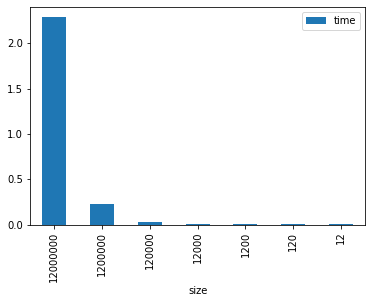

In [25]:
graph = pdf_size_time.plot.bar(x='size', y='time')

Even in memory, the time it takes to aggregate the counts is not negligible, and it would worsen with the larger size.

Depending on the available computing resources, this may vary. But after a certain threshold, it exhibits a linear growth of time needed to operate.

Now let's try with Spark:

In [26]:
df = df.withColumn('first', df.device_id.substr(0, 1))
df.show()

+--------------------+-----+
|           device_id|first|
+--------------------+-----+
|47afe935b8f45243f...|    4|
|9dcc4074aae530935...|    9|
|6f1cc31ab0b8aeac8...|    6|
|1255fd9b34f4cf3f9...|    1|
|2961e4f3c3a6b9937...|    2|
|b1039161a48385115...|    b|
|56da382007ec9d08e...|    5|
|4ac4d0dc3171da9a3...|    4|
|98973d79af19fbc0d...|    9|
|6e27e950fc31b25a3...|    6|
|32bd28251b8c8289e...|    3|
|1c53b11a82ecc3ef3...|    1|
|95fccb3112410f759...|    9|
|1c330093580a2f39e...|    1|
|28f18e96294d898b7...|    2|
|33d8454e5ca202527...|    3|
|3c00225c2bccb6d0f...|    3|
|155bdf605c6a932db...|    1|
|f44773cb771118ec9...|    f|
|0ad04a18e2df495bd...|    0|
+--------------------+-----+
only showing top 20 rows



From the above examples, we already know that Spark DataFrames, due to an entirely different and more complex mechanism compared to the more direct in-memory model that Pandas employs, the sampling process may be more time-consuming. Therefore the runtime of the entire while loop logic may take much longer, but the aggregation portion is captured precisely like its Pandas counterpart.

Fortunately, we can instruct Spark to initiate caching to minimize roundtrips between disks and the memory space:

In [27]:
df = df.cache()  # prepare the cache 

In [28]:
%%time

size_time = []
count = 12000000  # we already know the total record count
size = count

while size > 1:
    sample = df.sample(size / count)
    _count = sample.count()
    start = time.time()
    sample.groupby('first').agg({'device_id': 'count'}).collect()  # collect is used to emulate full data scan/process
    end = time.time()
    size_time.append({
        'size': _count,
        'time': end - start,
    })
    size = size // 10

df_size_time = pd.DataFrame(size_time)
df_size_time

CPU times: user 253 ms, sys: 161 ms, total: 414 ms
Wall time: 27.2 s


,size,time
0,12000000,1.865914
1,1200731,0.853110
2,119643,0.877328
3,12173,1.012259
4,1162,1.152587
5,120,0.793524
6,12,0.783296


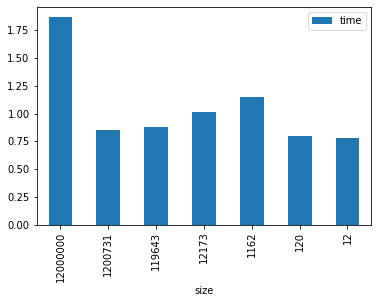

In [29]:
graph = df_size_time.plot.bar(x='size', y='time')

While it is significantly slower to bootstrap the samples, the aggregation shows a glimpse of Spark's true strength (or the distributed filesystem and the MapReduce model behind it). 

The time it takes to compute the aggregation can be nearly uniform regardless of the given sample size. This scalability characteristic becomes more prominent and essential as a tool to process data when the sample size goes beyond a single machine's capacity, much like the situation that Google encountered in the early 2000s.

Since its inception, Apache Spark has stayed current thanks to the contributions from open-source participants. For example, it has stream processing support for a more incremental instead of a large batch of MapReduce tasks to achieve near real-time analytics and more.

![spark more](https://user-images.githubusercontent.com/2837532/123450843-24e45600-d5ab-11eb-86d7-e5584adf42f9.png)

## Remarks

We can leverage techniques such as multiprocessing, multithreading, or coroutines to expedite data processing.

When the data size is much more than a single machine can handle, tools such as Apache Spark become vital to get the job done in a timely and cost-effective manner.

![EMR](https://user-images.githubusercontent.com/2837532/123005848-c89fed00-d384-11eb-8967-2e78faf718f2.png)

## References

* [Apache Spark](https://spark.apache.org/) and its [PySpark interface](https://spark.apache.org/docs/latest/api/python/index.html)
* [Python Coroutines and Tasks](https://docs.python.org/3/library/asyncio-task.html)
* [Part 11 - Work with SQL](../11-work-with-sql.ipynb)
* [Part 12 - Generate Data](../12-generate-data.ipynb)
* [Part 13 - The Power of Parallel Processing feat. multithreading and multiprocessing](../13-data-processing.ipynb)